In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.15.0', '1.23.5')

In [37]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = r"/content/drive/MyDrive/few-shot-learning/train/whale"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    print("error1 in path")
    image = cv2.imread(path)
    print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("error3")
    return image

In [38]:
# Zileanous testing ground
import os
import glob

def read_image(index):
    folder, _ = index
    path = os.path.join(ROOT, folder)

    # Get a list of all image files in the folder
    image_files = glob.glob(os.path.join(path, '*'))

    # If there are no image files, return None
    if not image_files:
        print(f"No image files in folder: {path}")
        return None

    # Sort the image files and select the first one
    image_file = sorted(image_files)[0]

    # Read and convert the image
    try:
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error reading file {image_file}: {e}")
        return None

    return img



In [39]:
# def split_dataset(directory, split=0.9):
#     folders = os.listdir(directory)
#     num_train = int(len(folders)*split)

#     random.shuffle(folders)

#     train_list, test_list = {}, {}

#     # Creating Train-list
#     for folder in folders[:num_train]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         train_list[folder] = num_files

#     # Creating Test-list
#     for folder in folders[num_train:]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         test_list[folder] = num_files

#     return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=0.9)
# print("Length of training list:", len(train_list))
# print("Length of testing list :", len(test_list))

# # train_list, test list contains the folder names along with the number of files in the folder.
# print("\nTest List:", test_list)

In [40]:
# from PIL import Image

# def resize_image(image_path, size=(128, 128)):
#     with Image.open(image_path) as img:
#         img = img.resize((128, 128))
#         img.save(image_path)

# def split_dataset(directory, split=0.9):
#     folders = os.listdir(directory)
#     num_train = int(len(folders)*split)

#     random.shuffle(folders)

#     train_list, test_list = {}, {}

#     # Creating Train-list
#     for folder in folders[:num_train]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         train_list[folder] = num_files

#         # Resize images in the folder
#         for filename in os.listdir(os.path.join(directory, folder)):
#             resize_image(os.path.join(directory, folder, filename))

#     # Creating Test-list
#     for folder in folders[num_train:]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         test_list[folder] = num_files

#         # Resize images in the folder
#         for filename in os.listdir(os.path.join(directory, folder)):
#             resize_image(os.path.join(directory, folder, filename))

#     return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=0.9)
# print("Length of training list:", len(train_list))
# print("Length of testing list :", len(test_list))

# # train_list, test list contains the folder names along with the number of files in the folder.
# print("\nTest List:", test_list)


In [41]:
import tensorflow as tf
batch_size = 128
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)




Length of training list: 45
Length of testing list : 5

Test List: {'48': 8, '29': 11, '47': 12, '23': 10, '44': 9}


In [42]:
# # Assuming anchor, positive, negative are your input tensors
# anchor = tf.random.normal([batch_size, 128, 128, 3])
# positive = tf.random.normal([batch_size, 128, 128, 3])
# negative = tf.random.normal([batch_size, 128, 128, 3])

# # Reshape the data
# anchor = tf.reshape(anchor, (batch_size, 128, 128, 3))
# positive = tf.reshape(positive, (batch_size, 128, 128, 3))
# negative = tf.reshape(negative, (batch_size, 128, 128, 3))

In [43]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [44]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 1595
Number of testing triplets : 199

Examples of triplets:
(('34', '5.jpg'), ('34', '8.jpg'), ('42', '5.jpg'))
(('17', '3.jpg'), ('17', '7.jpg'), ('15', '2.jpg'))
(('13', '5.jpg'), ('13', '9.jpg'), ('18', '5.jpg'))
(('40', '1.jpg'), ('40', '5.jpg'), ('32', '7.jpg'))
(('9', '4.jpg'), ('9', '6.jpg'), ('6', '2.jpg'))


In [45]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = [tf.convert_to_tensor(a, dtype=tf.float32) for a in anchor]
            positive = [tf.convert_to_tensor(p, dtype=tf.float32) for p in positive]
            negative = [tf.convert_to_tensor(n, dtype=tf.float32) for n in negative]




        yield ([anchor, positive, negative])

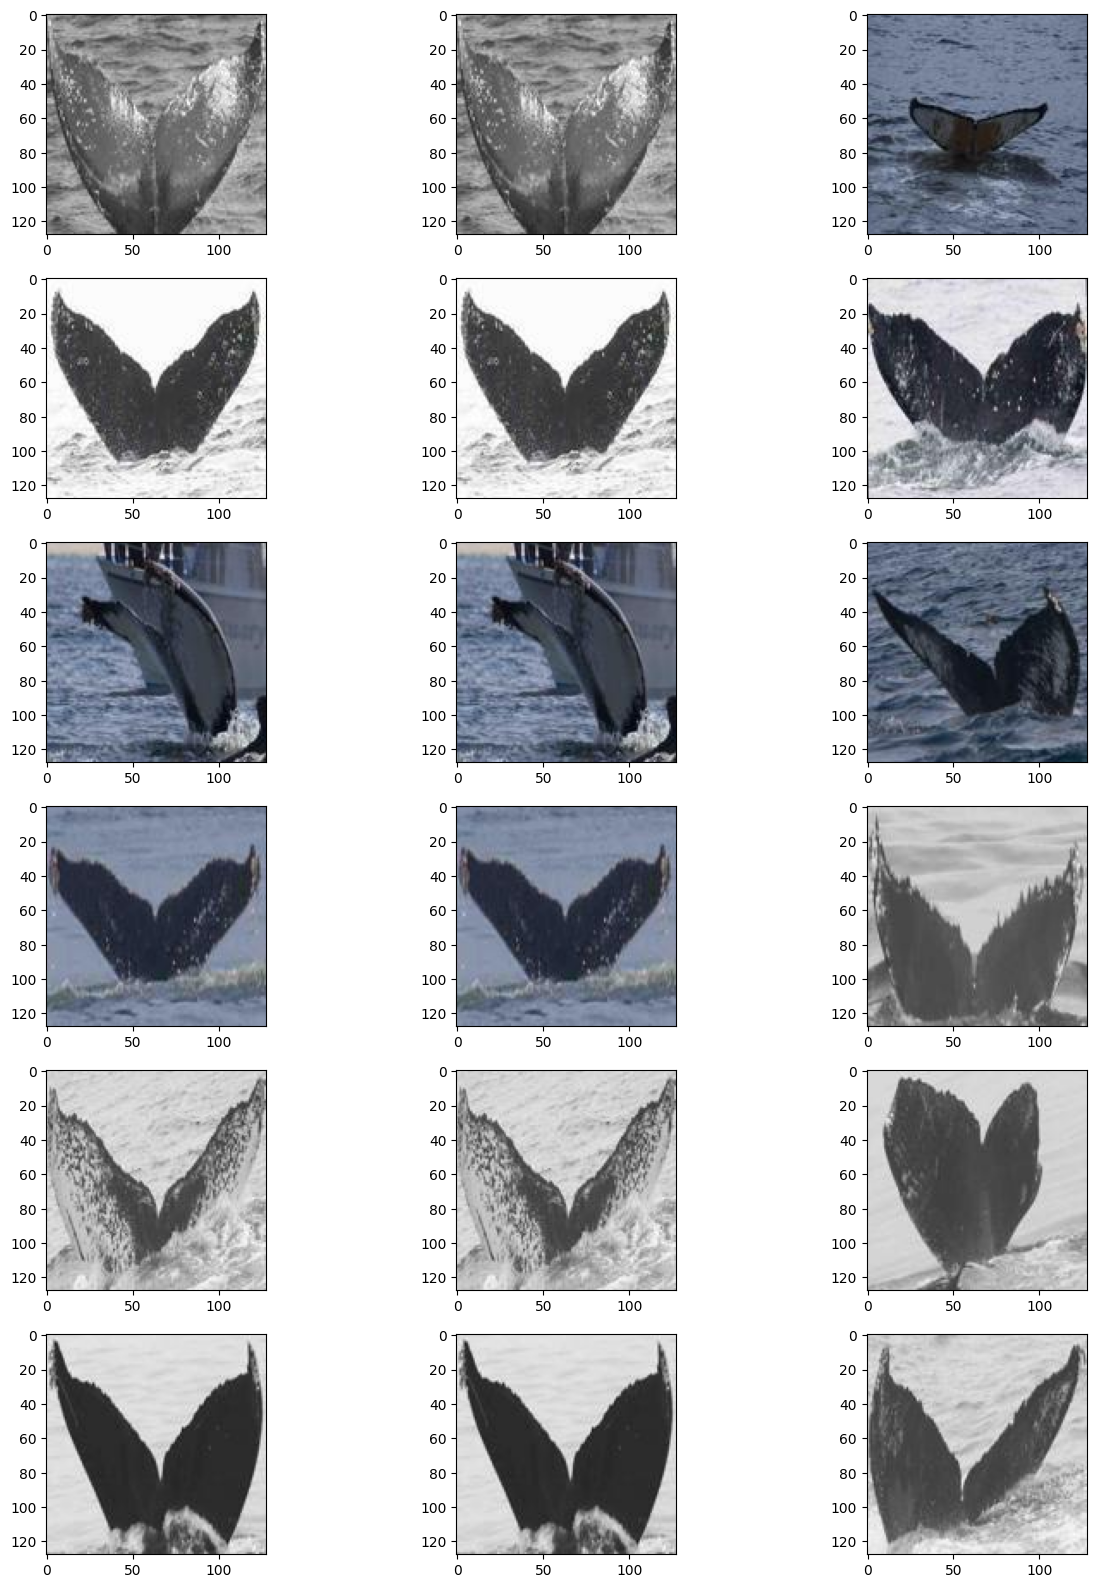

In [46]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [47]:
!pip install tensorflow
!pip install keras-applications
!pip install keras-preprocessing
import tensorflow
from tensorflow.keras import backend, layers, metrics
from keras.preprocessing import image as imagenet_utils
# from keras.preprocessing.image import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [48]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [49]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                    

In [50]:
# print(anchor.shape)
# print(positive.shape)
# print(negative.shape)


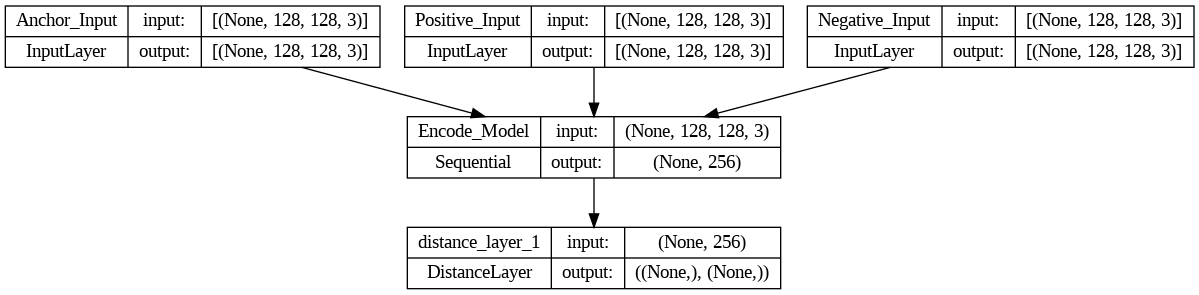

In [51]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [52]:
# !pip install keras
# import keras
# @keras.saving.register_keras_serializable()
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        print('error :__init__')
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        print('error :call')
        return self.siamese_network(inputs)

    def train_step(self, data):
        print('error :call')
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # print('error :test_step')
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # print('error :_compute_loss')
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [53]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)


error :__init__


In [54]:
# def test_on_triplets(batch_size = 256):
#     pos_scores, neg_scores = [], []

#     for data in get_batch(test_triplet, batch_size=batch_size):
#         prediction = siamese_model.predict(data)
#         pos_scores += list(prediction[0])
#         neg_scores += list(prediction[1])

#     accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
#     ap_mean = np.mean(pos_scores)
#     an_mean = np.mean(neg_scores)
#     ap_stds = np.std(pos_scores)
#     an_stds = np.std(neg_scores)

#     print(f"Accuracy on test = {accuracy:.5f}")
#     return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [55]:
import numpy as np

def test_on_triplets(batch_size=256):
    pos_scores, neg_scores = [], []

    for batch in get_batch(test_triplet, batch_size=batch_size):
        # Unpack the data into anchor, positive, and negative
        anchor, positive, negative = batch

        # Convert lists to NumPy arrays
        anchor_np = np.array(anchor)
        positive_np = np.array(positive)
        negative_np = np.array(negative)

        # Pass the inputs to the model as separate arguments
        predictions = siamese_model.predict([anchor_np, positive_np, negative_np])

        pos_scores.extend(predictions[0].tolist())
        neg_scores.extend(predictions[1].tolist())

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)




In [56]:
# print(anchor.shape)
# print(positive.shape)
# print(negative.shape)


In [57]:
# save_all = False
# epochs = 10
# batch_size = 128

# max_acc = 0
# train_loss = []
# test_metrics = []

# for epoch in range(1, epochs+1):
#     t = time.time()

#     # Training the model on train data
#     epoch_loss = []
#     for data in get_batch(train_triplet, batch_size=batch_size):
#         # Convert lists to TensorFlow tensors
#         anchor = tf.convert_to_tensor(data[0])
#         positive = tf.convert_to_tensor(data[1])
#         negative = tf.convert_to_tensor(data[2])

#         # Train the model
#         loss = siamese_model.train_on_batch([anchor, positive, negative])
#         epoch_loss.append(loss)
#     epoch_loss = sum(epoch_loss)/len(epoch_loss)
#     train_loss.append(epoch_loss)

#     print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
#     print(f"Loss on train    = {epoch_loss:.5f}")
#     # Testing the model on test data
#     metric = test_on_triplets(batch_size=batch_size)
#     test_metrics.append(metric)
#     accuracy = metric[0]

# # # Saving the model weights
# #     if save_all or accuracy>=max_acc:
# #         siamese_model.save_weights("siamese_model")
# #         max_acc = accuracy

# # # Saving the model after all epochs run
# # siamese_model.save_weights("siamese_model-final")


In [58]:
import time
import tensorflow as tf
import pickle

save_all = False
epochs = 60
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        # Convert lists to TensorFlow tensors
        anchor = tf.convert_to_tensor(data[0])
        positive = tf.convert_to_tensor(data[1])
        negative = tf.convert_to_tensor(data[2])

        # Train the model
        loss = siamese_model.train_on_batch([anchor, positive, negative])
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)

    # Save the model after the final epoch
    if epoch == epochs:
        with open('siamese_model.pkl', 'wb') as f:
            pickle.dump(siamese_model, f)


error :call
error :call
error :call

EPOCH: 1 	 (Epoch done in 54 sec)
Loss on train    = 0.21962
error :call
4/4 [==============================] - 2s 151ms/step
error :call
3/3 [==============================] - 3s 161ms/step
Accuracy on test = 1.00000

EPOCH: 2 	 (Epoch done in 23 sec)
Loss on train    = 0.04285
3/3 [==============================] - 0s 114ms/step
Accuracy on test = 1.00000

EPOCH: 3 	 (Epoch done in 23 sec)
Loss on train    = 0.02159
3/3 [==============================] - 0s 117ms/step
Accuracy on test = 1.00000

EPOCH: 4 	 (Epoch done in 25 sec)
Loss on train    = 0.00863
3/3 [==============================] - 0s 119ms/step
Accuracy on test = 1.00000

EPOCH: 5 	 (Epoch done in 24 sec)
Loss on train    = 0.00733
3/3 [==============================] - 0s 114ms/step
Accuracy on test = 1.00000

EPOCH: 6 	 (Epoch done in 24 sec)
Loss on train    = 0.00868
3/3 [==============================] - 0s 119ms/step
Accuracy on test = 1.00000

EPOCH: 7 	 (Epoch done in 24 sec)


Accuracy on test = 1.00000


In [59]:
# Specify the path where you want to save your model
model_save_path = '/content/drive/MyDrive/few-shot-learning.h5'

# Save the model in TensorFlow SavedModel format
# siamese_model.save(model_save_path)


In [60]:
# def extract_encoder(model):
#     encoder = get_encoder((128, 128, 3))
#     i=0
#     for e_layer in model.layers[0].layers[3].layers:
#         layer_weight = e_layer.get_weights()
#         encoder.layers[i].set_weights(layer_weight)
#         i+=1
#     return encoder

# encoder = extract_encoder(siamese_model)
# encoder.save_weights("encoder")
# encoder.summary()

In [61]:
import pickle

def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)

# # Save the encoder model using pickle
# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

encoder.summary()


Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_19 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 lambda_3 (Lambda)           (None, 256)               0         
                                                      

In [62]:
encoder.save('/content/drive/MyDrive/few-shot-learning/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Convert the input lists to numpy arrays if they aren't already

    face_list1 = np.array(face_list1)
    face_list2 = np.array(face_list2)

    # Ensure the input arrays have the correct number of dimensions
    if len(face_list1.shape) == 1:
        face_list1 = np.expand_dims(face_list1, axis=0)
    if len(face_list2.shape) == 1:
        face_list2 = np.expand_dims(face_list2, axis=0)

    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


<class 'list'>
7/7 [==============================] - 0s 39ms/step

Accuracy of model: 0.9597989949748744



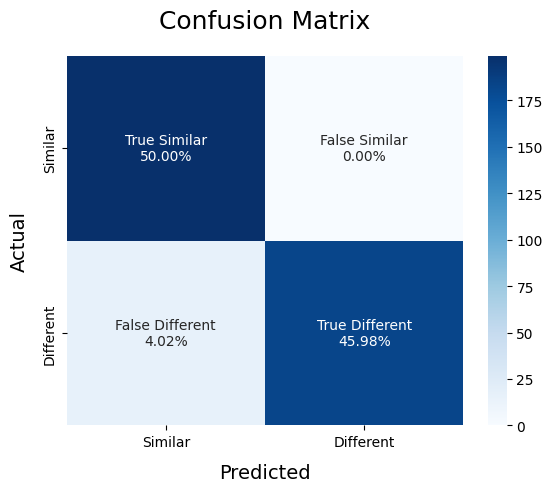

In [64]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    print(type(a))
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [65]:
# from google.colab import files
# files.download("/content/siamese_model.pkl")

In [66]:
print(type(a))


<class 'list'>


In [67]:
nt=np.array(a)

In [68]:
print(type(nt))

<class 'numpy.ndarray'>
